In [48]:
library("tidyverse")
library("DT")
library("ggplot2")
library("dplyr")
library(cluster)
library(pheatmap)
library(tigris)
library(sf)
library(geojsonio)
library(corrplot)
library("ggrepel")
library("ggcorrplot")

In [111]:
snapshot_urlfile = "https://raw.githubusercontent.com/ncliu95/smu_dm_project_2/main/texas_snapshot_with_census_pol.csv"

In [112]:
snapshot_cases <- read_csv(url(snapshot_urlfile))

Rows: 254 Columns: 270
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (9): county_name.x, state.x, state.y, state_po, county_name.y, office...
dbl  (250): county_fips_code, state_fips_code, confirmed_cases, deaths, geo_...
lgl   (10): pop_5_years_over, speak_only_english_at_home, speak_spanish_at_h...
date   (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [113]:
snapshot_cases <- snapshot_cases %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases,
    hispanic_ratio = hispanic_pop/total_pop,
    percent_male_pop = male_pop/total_pop,
    percent_female_pop = female_pop/total_pop,
    white_ratio = white_pop/total_pop,
    black_ratio = black_pop/total_pop,
    asian_ratio = asian_pop/total_pop,
    amerindian_ratio = amerindian_pop/total_pop,
    other_race_ratio = other_race_pop/total_pop,
    percent_unemployed = unemployed_pop/total_pop,
    percent_children = children/total_pop,
    percent_employed_agriculture_forestry_fishing_hunting_mining = employed_agriculture_forestry_fishing_hunting_mining/total_pop,
    percent_employed_arts_entertainment_recreation_accommodation_food = employed_arts_entertainment_recreation_accommodation_food/total_pop,
    percent_employed_construction = employed_construction/total_pop,
    percent_employed_education_health_social = employed_education_health_social/total_pop,
    percent_employed_finance_insurance_real_estate = employed_finance_insurance_real_estate/total_pop,
    percent_employed_information = employed_information/total_pop,
    percent_employed_manufacturing = employed_manufacturing/total_pop,
    percent_employed_other_services_not_public_admin = employed_other_services_not_public_admin/total_pop,
    percent_employed_public_administration = employed_public_administration/total_pop,
    percent_employed_retail_trade = employed_retail_trade/total_pop,
    percent_employed_science_management_admin_waste = employed_science_management_admin_waste/total_pop,
    percent_employed_transportation_warehousing_utilities = employed_transportation_warehousing_utilities/total_pop,
    percent_employed_wholesale_trade = employed_wholesale_trade/total_pop,
    percent_unemployed = unemployed_pop/total_pop,
    percent_children = children/total_pop,
    percent_commute_by_bus = commuters_by_bus/employed_pop,
    percent_commute_by_car_truck_van = commuters_by_car_truck_van/employed_pop,
    percent_commute_by_carpool = commuters_by_carpool/employed_pop,
    percent_commute_by_subway = commuters_by_subway_or_elevated/employed_pop,
    percent_commute_by_driving_alone = commuters_drove_alone/employed_pop,
    percent_wfh = worked_at_home/employed_pop
)

In [114]:
# Download county data for Texas
tx_counties <- counties(state = "TX")
tx_counties$GEOID <- as.numeric(tx_counties$GEOID)
snapshot_cases <- left_join(snapshot_cases, tx_counties[, c("GEOID", "ALAND")], by = c("county_fips_code" = "GEOID"))
snapshot_cases <- snapshot_cases %>% mutate(
  pop_density = total_pop/ALAND)
    

Retrieving data for the year 2021



In [116]:
data <- select(snapshot_cases, 
                  'county_name.x',
'median_income',
'cases_per_1000',
'deaths_per_1000',
'death_per_case',
'hispanic_ratio',
'pop_density',
'party',
'median_age',
'poverty',
'bachelors_degree',   
'commuters_by_public_transportation',
'percent_male_pop',
'percent_female_pop',
'median_age',
'median_rent',
'white_ratio',
'black_ratio',
'asian_ratio',
'amerindian_ratio',
'other_race_ratio',
'percent_employed_agriculture_forestry_fishing_hunting_mining',
'percent_employed_arts_entertainment_recreation_accommodation_food', 
'percent_employed_construction' ,
'percent_employed_education_health_social',
'percent_employed_finance_insurance_real_estate',
'percent_employed_information', 
'percent_employed_manufacturing', 
'percent_employed_other_services_not_public_admin',
'percent_employed_public_administration',
'percent_employed_retail_trade',
'percent_employed_science_management_admin_waste',
'percent_employed_transportation_warehousing_utilities',
'percent_employed_wholesale_trade',
'percent_unemployed',
'percent_children',
 'percent_commute_by_bus',
'percent_commute_by_car_truck_van',
'percent_commute_by_carpool',
'percent_commute_by_subway',
'percent_commute_by_driving_alone',
'percent_wfh'             )

In [117]:
data <- data %>% mutate(party = ifelse(party == "REPUBLICAN", 0, 1))

In [107]:
# Select the numeric columns in the data frame
num_cols <- sapply(data, is.numeric)

# Apply the scale() function to the numeric columns
data[num_cols] <- scale(data[num_cols])

In [119]:
summary(data)

 county_name.x      median_income   cases_per_1000   deaths_per_1000
 Length:254         Min.   :24794   Min.   : 13.51   Min.   :0.000  
 Class :character   1st Qu.:42327   1st Qu.: 58.96   1st Qu.:1.199  
 Mode  :character   Median :48311   Median : 73.94   Median :1.727  
                    Mean   :49894   Mean   : 77.99   Mean   :1.855  
                    3rd Qu.:55741   3rd Qu.: 94.10   3rd Qu.:2.394  
                    Max.   :93645   Max.   :182.90   Max.   :6.284  
 death_per_case    hispanic_ratio     pop_density            party        
 Min.   :0.00000   Min.   :0.03454   Min.   :4.270e-08   Min.   :0.00000  
 1st Qu.:0.01482   1st Qu.:0.17870   1st Qu.:2.488e-06   1st Qu.:0.00000  
 Median :0.02262   Median :0.26378   Median :8.325e-06   Median :0.00000  
 Mean   :0.02469   Mean   :0.34518   Mean   :4.402e-05   Mean   :0.08661  
 3rd Qu.:0.03087   3rd Qu.:0.49730   3rd Qu.:2.449e-05   3rd Qu.:0.00000  
 Max.   :0.09322   Max.   :0.99185   Max.   :1.129e-03   Max.   :1.

In [124]:
# Socioeconomic Indicators:
se_data <- subset(data, select = c(county_name.x, cases_per_1000, deaths_per_1000, death_per_case, median_income, poverty, median_rent, percent_employed_agriculture_forestry_fishing_hunting_mining, percent_employed_arts_entertainment_recreation_accommodation_food, percent_employed_construction, percent_employed_education_health_social, percent_employed_finance_insurance_real_estate, percent_employed_information, percent_employed_manufacturing, percent_employed_other_services_not_public_admin, percent_employed_public_administration, percent_employed_retail_trade, percent_employed_science_management_admin_waste, percent_employed_transportation_warehousing_utilities, percent_employed_wholesale_trade, percent_unemployed))
write.csv(se_data, "socioeconomic_feature_set.csv")
colnames(se_data)

[1] "county_name.x"                                                    
 [2] "cases_per_1000"                                                   
 [3] "deaths_per_1000"                                                  
 [4] "death_per_case"                                                   
 [5] "median_income"                                                    
 [6] "poverty"                                                          
 [7] "median_rent"                                                      
 [8] "percent_employed_agriculture_forestry_fishing_hunting_mining"     
 [9] "percent_employed_arts_entertainment_recreation_accommodation_food"
[10] "percent_employed_construction"                                    
[11] "percent_employed_education_health_social"                         
[12] "percent_employed_finance_insurance_real_estate"                   
[13] "percent_employed_information"                                     
[14] "percent_employed_manufacturing"                                   
[15] "percent_employed_other_services_not_public_admin"                 
[16] "percent_employed_public_administration"                           
[17] "percent_employed_retail_trade"                                    
[18] "percent_employed_science_management_admin_waste"                  
[19] "percent_employed_transportation_warehousing_utilities"            
[20] "percent_employed_wholesale_trade"                                 
[21] "percent_unemployed"

In [125]:
#  Demographic Indicators
demo_data <- subset(data, select = c(    
    county_name.x,
    cases_per_1000,
    deaths_per_1000,
    death_per_case,
    hispanic_ratio,
    median_age,
    bachelors_degree,
    percent_male_pop,
    percent_female_pop,
    white_ratio,
    black_ratio,
    asian_ratio,
    amerindian_ratio,
    other_race_ratio,
    percent_children))
write.csv(demo_data, "demographic_feature_set.csv")
colnames(demo_data)

[1] "county_name.x"      "cases_per_1000"     "deaths_per_1000"   
 [4] "death_per_case"     "hispanic_ratio"     "median_age"        
 [7] "bachelors_degree"   "percent_male_pop"   "percent_female_pop"
[10] "white_ratio"        "black_ratio"        "asian_ratio"       
[13] "amerindian_ratio"   "other_race_ratio"   "percent_children"

In [126]:
#  Transportation Metrics
transport_data <- subset(data, select = c(
county_name.x,
    cases_per_1000,
    deaths_per_1000,
    death_per_case,
    pop_density,
    commuters_by_public_transportation,
    percent_commute_by_bus,
    percent_commute_by_car_truck_van,
    percent_commute_by_carpool,
    percent_commute_by_subway,
    percent_commute_by_driving_alone,
    percent_wfh)
)
write.csv(transport_data, "transportation_feature_set.csv")
colnames(transport_data)

[1] "county_name.x"                      "cases_per_1000"                    
 [3] "deaths_per_1000"                    "death_per_case"                    
 [5] "pop_density"                        "commuters_by_public_transportation"
 [7] "percent_commute_by_bus"             "percent_commute_by_car_truck_van"  
 [9] "percent_commute_by_carpool"         "percent_commute_by_subway"         
[11] "percent_commute_by_driving_alone"   "percent_wfh"

In [127]:
#  Employment and Industry Indicators
emp_data <- subset(data, select = c(
    county_name.x,
    cases_per_1000,
    deaths_per_1000,
    death_per_case,
    percent_employed_agriculture_forestry_fishing_hunting_mining,
    percent_employed_arts_entertainment_recreation_accommodation_food,
    percent_employed_construction,
    percent_employed_education_health_social,
    percent_employed_finance_insurance_real_estate,
    percent_employed_information,
    percent_employed_manufacturing,
    percent_employed_other_services_not_public_admin,
    percent_employed_public_administration,
    percent_employed_retail_trade,
    percent_employed_science_management_admin_waste,
    percent_employed_transportation_warehousing_utilities,
    percent_employed_wholesale_trade,
    percent_unemployed)
)
write.csv(emp_data, "employment_and_industry_feature_set.csv")
colnames(emp_data)

[1] "county_name.x"                                                    
 [2] "cases_per_1000"                                                   
 [3] "deaths_per_1000"                                                  
 [4] "death_per_case"                                                   
 [5] "percent_employed_agriculture_forestry_fishing_hunting_mining"     
 [6] "percent_employed_arts_entertainment_recreation_accommodation_food"
 [7] "percent_employed_construction"                                    
 [8] "percent_employed_education_health_social"                         
 [9] "percent_employed_finance_insurance_real_estate"                   
[10] "percent_employed_information"                                     
[11] "percent_employed_manufacturing"                                   
[12] "percent_employed_other_services_not_public_admin"                 
[13] "percent_employed_public_administration"                           
[14] "percent_employed_retail_trade"                                    
[15] "percent_employed_science_management_admin_waste"                  
[16] "percent_employed_transportation_warehousing_utilities"            
[17] "percent_employed_wholesale_trade"                                 
[18] "percent_unemployed"

In [133]:
library(cluster)
library(ggplot2)

# Read in the data
df <- emp_data

# Select the columns to use for clustering
vars <-names(df)
# Remove any rows with missing data
df <- na.omit(df[, c("county_name.x", vars)])

# Perform fuzzy clustering with 2 clusters
set.seed(123) # for reproducibility
clusters <- fanny(df[, vars], k = 2, memb.exp = 1.5)

# Add the cluster assignments to the original data frame
df$cluster <- clusters$membership

vars


[1] "county_name.x"                                                    
 [2] "cases_per_1000"                                                   
 [3] "deaths_per_1000"                                                  
 [4] "death_per_case"                                                   
 [5] "percent_employed_agriculture_forestry_fishing_hunting_mining"     
 [6] "percent_employed_arts_entertainment_recreation_accommodation_food"
 [7] "percent_employed_construction"                                    
 [8] "percent_employed_education_health_social"                         
 [9] "percent_employed_finance_insurance_real_estate"                   
[10] "percent_employed_information"                                     
[11] "percent_employed_manufacturing"                                   
[12] "percent_employed_other_services_not_public_admin"                 
[13] "percent_employed_public_administration"                           
[14] "percent_employed_retail_trade"                                    
[15] "percent_employed_science_management_admin_waste"                  
[16] "percent_employed_transportation_warehousing_utilities"            
[17] "percent_employed_wholesale_trade"                                 
[18] "percent_unemployed"

In [132]:

# Create a scatter plot of confirmed cases vs. median income, colored by cluster
ggplot(df, aes(x = cases_per_1000, y = deaths_per_1000)) + 
  geom_point() +
  labs(title = "Fuzzy Clustering Results", x = "cases per 1000", y = "deaths per 1000") +
  theme_bw()

ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `FUN()`:
! `data` must be uniquely named but has duplicate columns

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.r

In [134]:
df

county_name.x,county_name.x,cases_per_1000,deaths_per_1000,death_per_case,percent_employed_agriculture_forestry_fishing_hunting_mining,percent_employed_arts_entertainment_recreation_accommodation_food,percent_employed_construction,percent_employed_education_health_social,percent_employed_finance_insurance_real_estate,percent_employed_information,percent_employed_manufacturing,percent_employed_other_services_not_public_admin,percent_employed_public_administration,percent_employed_retail_trade,percent_employed_science_management_admin_waste,percent_employed_transportation_warehousing_utilities,percent_employed_wholesale_trade,percent_unemployed,cluster
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,2]>"
Anderson County,Anderson County,96.54181,1.2987688,0.013452915,0.030598992,0.01830398,0.01660692,0.07505152,0.010286249,0.0028746082,0.019013975,0.01348988,0.032521170,0.06197725,0.022944915,0.020399328,0.006718964,0.014719379,"0.9323341, 0.06766592"
Andrews County,Andrews County,91.36940,2.1050236,0.023038605,0.132104455,0.02565853,0.03538715,0.06218354,0.023610400,0.0027308414,0.024236218,0.01456449,0.007339136,0.04249872,0.037492177,0.044774421,0.005632360,0.021789839,"0.9379996, 0.06200041"
Angelina County,Angelina County,77.13797,2.2006842,0.028529194,0.015062714,0.03452680,0.02462942,0.11478905,0.017685291,0.0030216648,0.050661345,0.02405929,0.016716078,0.05516534,0.029304447,0.018164196,0.008574686,0.033876853,"0.9455419, 0.05445808"
Aransas County,Aransas County,36.04220,1.0470361,0.029050279,0.022350193,0.06028512,0.05851321,0.07345361,0.024162371,0.0018524485,0.018685567,0.02919620,0.019048003,0.05331830,0.033625966,0.012322809,0.011477126,0.030202964,"0.9180604, 0.08193965"
Archer County,Archer County,78.92642,1.1372683,0.014409222,0.051177073,0.01705902,0.03582395,0.11816217,0.025361083,0.0042078926,0.042875014,0.02240419,0.024678722,0.06755374,0.039463209,0.027180712,0.018082566,0.015125668,"0.9484587, 0.05154133"
Armstrong County,Armstrong County,66.35562,3.1104199,0.046875000,0.074650078,0.02384655,0.05754277,0.12130638,0.018662519,0.0093312597,0.025920166,0.02695697,0.038880249,0.03058580,0.030585796,0.030585796,0.012960083,0.009331260,"0.9488440, 0.05115605"
Atascosa County,Atascosa County,78.54338,1.8695860,0.023803227,0.043332849,0.03080662,0.04914934,0.08992709,0.021583332,0.0044454600,0.026942811,0.01794803,0.021105549,0.04599182,0.028646212,0.031159767,0.008745508,0.027399821,"0.9515972, 0.04840283"
Austin County,Austin County,47.93118,0.6145023,0.012820513,0.024375256,0.02625290,0.04700942,0.09193636,0.020244435,0.0031066503,0.057148710,0.01918613,0.020893077,0.06609313,0.043288270,0.027072238,0.014577359,0.026389458,"0.9388449, 0.06115509"
Bailey County,Bailey County,104.53649,2.1132713,0.020215633,0.077345731,0.03522119,0.05494505,0.06311637,0.009861933,0.0045083122,0.031980840,0.02662722,0.014088476,0.05001409,0.025077487,0.036630037,0.015356438,0.010143702,"0.9351033, 0.06489671"


In [16]:
counties <- as_tibble(map_data("county"))
counties_TX <- counties %>% dplyr::filter(region == "texas") %>% 
  rename(c(county = subregion))

In [17]:
df <- df %>% mutate(county = county_name.x %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

counties_TX_clust <- counties_TX %>% left_join(df)

Joining, by = "county"


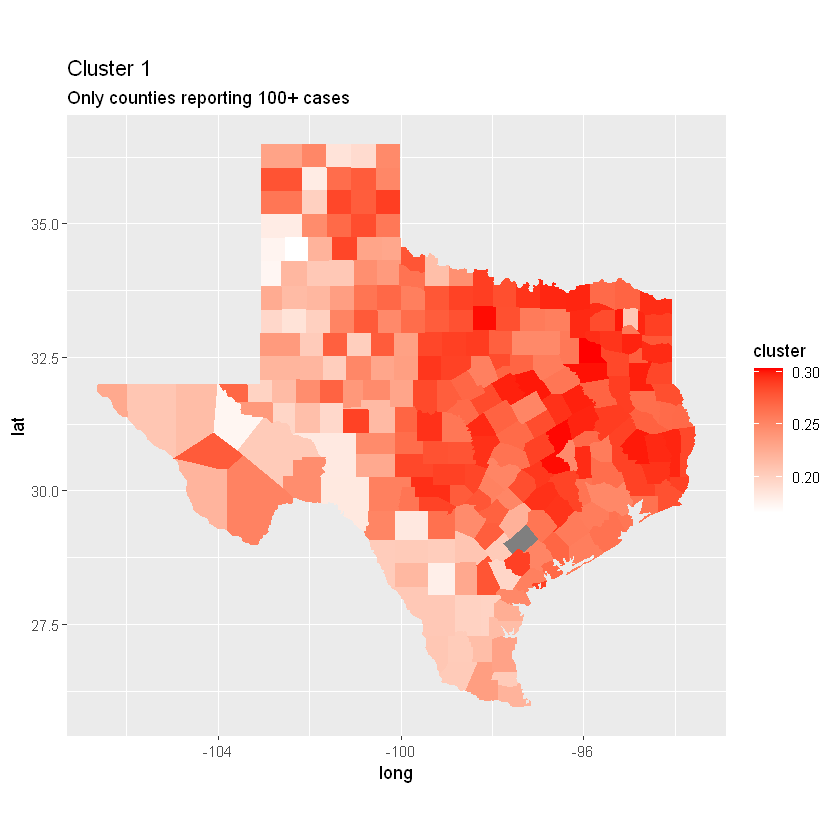

In [18]:
counties_TX_clust_1 <- counties_TX_clust %>% mutate(cluster = cluster[,1])
ggplot(counties_TX_clust_1, aes(long, lat)) + 
  geom_polygon(data = counties_TX_clust_1, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "red") +
  labs(title = "Cluster 1", subtitle = "Only counties reporting 100+ cases")

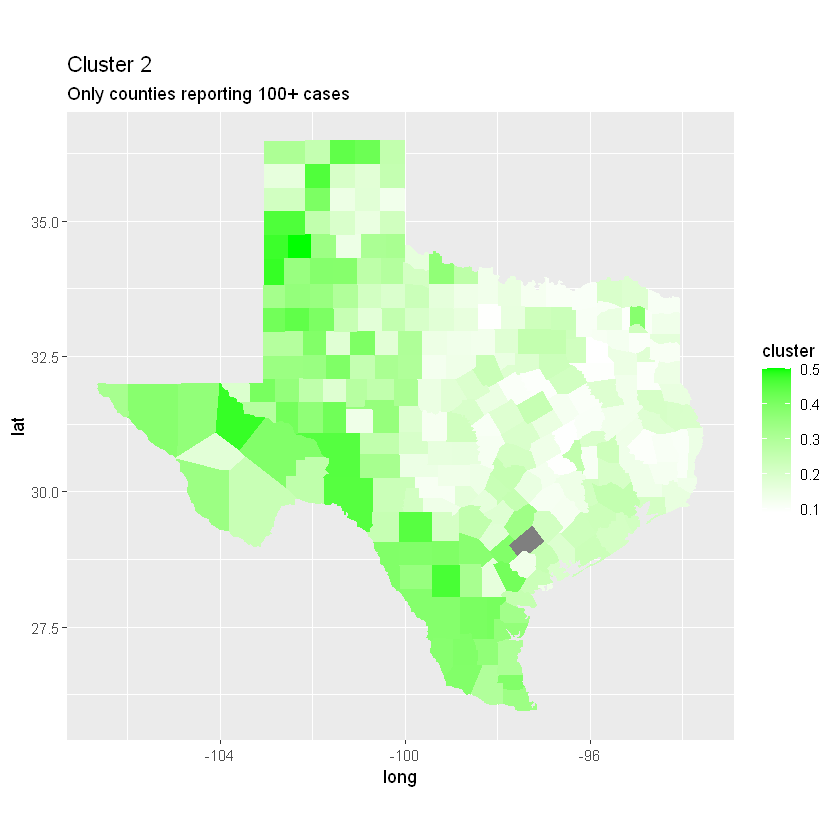

In [19]:
counties_TX_clust_2 <- counties_TX_clust %>% mutate(cluster = cluster[,2])
ggplot(counties_TX_clust_2, aes(long, lat)) + 
  geom_polygon(data = counties_TX_clust_2, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "green") +
  labs(title = "Cluster 2", subtitle = "Only counties reporting 100+ cases")

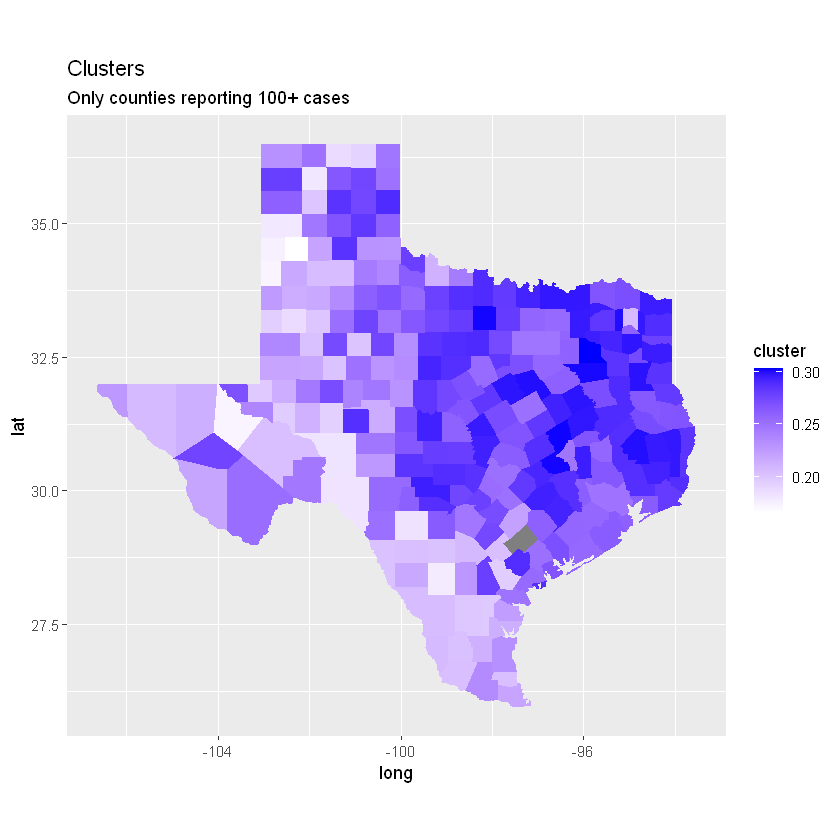

In [20]:
counties_TX_clust_3 <- counties_TX_clust %>% mutate(cluster = cluster[,3])
ggplot(counties_TX_clust_3, aes(long, lat)) + 
  geom_polygon(data = counties_TX_clust_3, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Clusters", subtitle = "Only counties reporting 100+ cases")

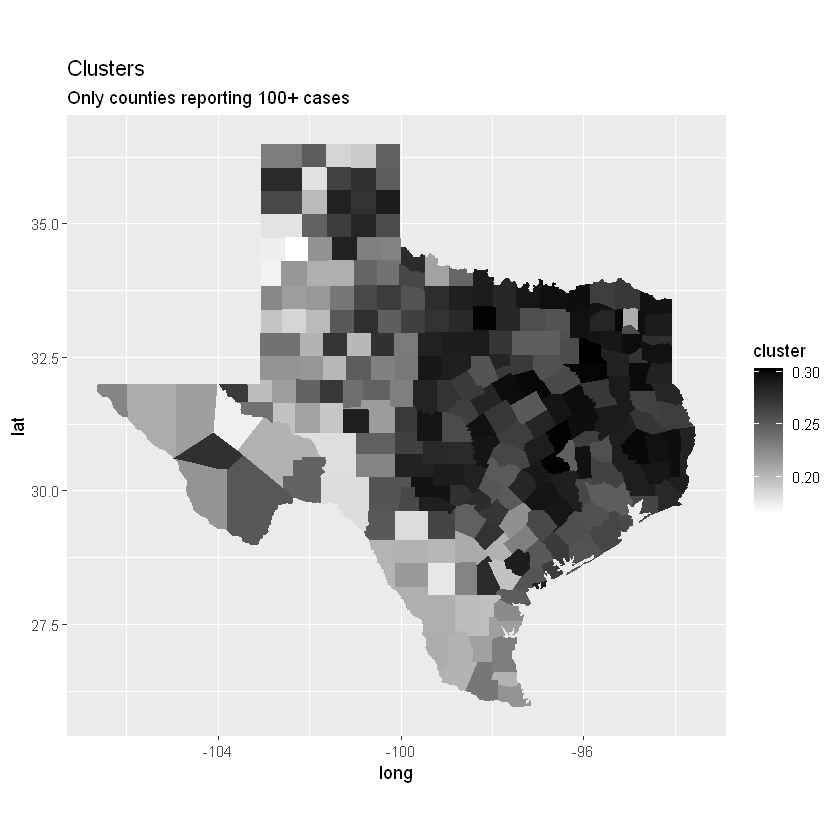

In [21]:
counties_TX_clust_4 <- counties_TX_clust %>% mutate(cluster = cluster[,4])
ggplot(counties_TX_clust_4, aes(long, lat)) + 
  geom_polygon(data = counties_TX_clust_4, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "black") +
  labs(title = "Clusters", subtitle = "Only counties reporting 100+ cases")